# Introduction to mempyDEB


This notebook is a walkthrough of the basic functionality of `mempyDEB`. <br>
It will show you how to load the package, run a simulation, modify parameters and plot results.

## Installation

The `mempyDEB` package can be installed with the command 

`pip install git+https://github.com/simonhansul/mempyDEB.git`

(e.g. in Anaconda prompt with the desired environment activated).

To run this notebook, additional packages listed below may have to be installed via pip. Some will be pre-installed through the conda distribution. In case of doubt, run:

`pip install matplotlib pandas seaborn`

## Notebook setup

Below we load some Python packages for plotting and dealing with data frames.

In [1]:
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # statistical plotting functions
sns.color_palette("viridis", as_cmap=True)
import pandas as pd # dataframes like in R
from copy import deepcopy

Now we can load some content from the mempyDEB package:

In [2]:
from mempyDEB.DEBODE.simulators import * # functions to run models
from mempyDEB.DEBODE.defaultparams import * # some default parameter configurations

## First simulation: Running the default parameters

By loading `defaultparams`, we have made the following object available:

This is a set of default parameters. It is defined as a named tuple, containing the entries `glb` and `spc`. <br>
`glb`stands for "global". These are global parameters, such as the timespan `tspan` to simulate, 
the food input rate `Xdot_in` and the (constant) chemical concentration `C_W`.

In [3]:
defaultparams_DEBBase.glb

{'tspan': (0, 23), 'a_int': 2, 'V_patch': 0.05, 'Xdot_in': 375, 'C_W': 0.0}

`spc` are species-specific parameters, i.e. the DEB and TKTD parameters.

In [4]:
defaultparams_DEBBase.spc

{'X_emb_int': 0.675,
 'eta_IA_0': 0.35,
 'eta_AS_0': 0.9,
 'eta_AR_0': 0.95,
 'Idot_max_rel': 4,
 'Idot_max_rel_emb': 4,
 'K_X': 500.0,
 'kappa': 0.9,
 'eta_SA': 0.9,
 'k_M_0': 0.4,
 'S_p': 9,
 'kD_j': 0.5,
 'ED50_j': 1.0,
 'beta_j': 2.0,
 'pmoa': 'G',
 'kD_h': 0.5,
 'ED50_h': 2.0,
 'beta_h': 1.0}

These parameter values are just some defaults for a hypothetical organism. Their only purpose is to help you get started and serve as a reference during implementation. <br>
<br>
The snippet below shows how the defaults are defined in `mempyDEB`, with a short explanation of each parameter. <br>
The specific implementation is a variant on DEBkiss, in which all state variables are expressend as length and surface area-scaling is done through a corresponding transformation of the structural mass ($A \propto S^{2/3}$).

```Python
# default parameters for the DEBBase model (a variant of DEBkiss with TKTD)
defaultparams_DEBBase = Params(
    { # global parameters
        # Simulation parameters
        'tspan' : (0,23), # simulated time span
        'a_int' : 2, # initial age (including embryonic development); the column `t` in the simulation output starts to count time at this age

        # Environmental parameters
        'V_patch':  0.05, # simulated volume (L)
        'Xdot_in': 375, # food input rate (µg C / d)
        'C_W' : 0. # chemical exposure concentration
    },
    { # species-specific parameters
        'X_emb_int': 0.675, # mass of an egg (µgC)
        'eta_IA_0': 0.35, # assimilation efficiency  (-)
        'eta_AS_0': 0.9, # growth efficency (-)
        'eta_AR_0': 0.95, # reproduction efficiency (-)
        'Idot_max_rel': 4,  # maximum specific ingestion rate (µgC µgC^-2/3 d^-1)
        'Idot_max_rel_emb': 4, # maximum specific ingestion rate for embryos (µgC µgC^-2/3 d^-1)
        'K_X': 0.5e3, # half-saturation constant for ingestion (µgC / L)
        'kappa': 0.9, # somatic investment fraction (-)
        'eta_SA': 0.9, # shrinking efficiency (-)
        'k_M_0': 0.4, # somatic maintenance constant (d^-1)
        'S_p': 9, # structural mass at puberty (µgC)

        # sublethal TKTD parameters 
        'kD_j' : .5, # dominant rate constant for sublethal effects (d^-1)
        'ED50_j' : 1., # median effective scaled damage for sublethal effects - this model assumes a log-logistic relationsip between damage and relative response on the DEB level (units chemical exposure)
        'beta_j' : 2., # slope for lethal effects (-)
        'pmoa' : 'G', # physiological mode of action (categorical: G, M, A, R)

        # GUTS-SD parameters
        'kD_h' : .5, #  dominant rate constant for lethal effects (d^-1)
        'ED50_h' : 2., # median effective scaled damage for lethal effects (units match chemical exposure)
        'beta_h' : 1. # slope for lethal effects (-)
    }
)
```

No we can run the `DEBBase` model like so:

In [5]:
sim = simulate_DEBBase(defaultparams_DEBBase);

What we get out is a `pd.DataFrame` object with the major state variables over time:

In [6]:
sim.head() # the head() method shows the first few rows to get an idea of the data structure

,S,R,X_emb,X,D_j,t
0,0.000010,0.0,0.675000,375.000000,0.0,-2
1,0.052864,0.0,0.470142,375.000000,0.0,-1
2,0.314850,0.0,-0.000104,546.477468,0.0,0
3,0.850994,0.0,-0.000104,918.877558,0.0,1
4,1.679849,0.0,-0.000104,1289.376940,0.0,2


An easy way to plot this is with `seaborn`, which nicely works with `pd.DataFrame`.

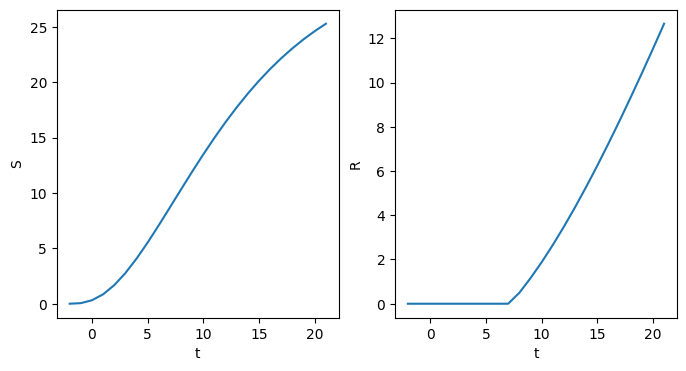

In [7]:
fig, ax = plt.subplots(ncols = 2, figsize = (8,4)) # creates a subplot with 3 columns

for (i,var) in enumerate(["S", "R"]): # for each of these variables
    sns.lineplot(sim, x = "t", y = var, ax = ax[i]) # plot it over time and place it on the ith subplot

We should see a continuous growth curve of `S` over time `t`, where `S` is structure expressed in $\mu g C$. For `R`, the plot should show an increase starting around day 7.

## Modifying parameters

Once we start to modify parameters, a good place to start is to create a copy of the default parameters:

In [8]:
myparams = deepcopy(defaultparams_DEBBase)

We need to explicitly call the `deepcopy` function to create an object which is independent of `defaultparams_DEBBase`. Otherwise, changing `myparams` would also change the defaults.

Now we can play with `myparams` without affecting the default. <br>
Below we iterate over several values of `kappa`:

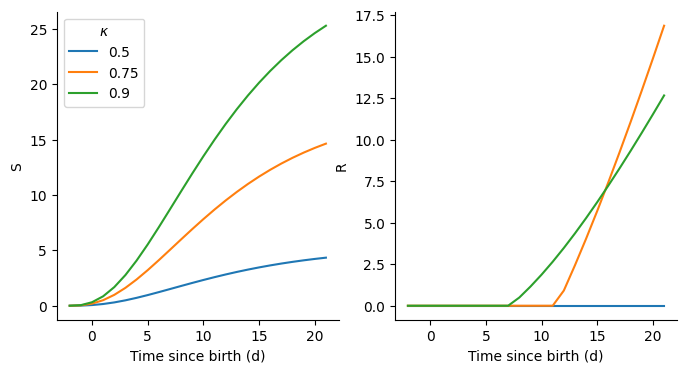

In [9]:
fig, ax = plt.subplots(ncols = 2, figsize = (8,4)) # creates a subplot with 3 columns

for kap in [0.5, 0.75, 0.9]:

    myparams.spc["kappa"] = kap

    sim = simulate_DEBBase(myparams)

    for (i,var) in enumerate(["S", "R"]): # for each of these variables
        sns.lineplot(sim, x = "t", y = var, ax = ax[i], label = kap); # plot it over time and place it on the ith subplot

ax[0].legend(title = r"$\kappa$") # add a legend title
ax[1].legend().remove() # remove legend for second subplot

# prettying up the plot a little
sns.despine() # this removes the boundary boxes
[a.set(xlabel = "Time since birth (d)") for a in ax];

## Simulating chemical effects

To simulate chemical effects, we could write a for-loop as above. <br>
Since this is a common thing to do, `mempyDEB` also provides a `constant_exposures` function, which is wrapped around the simulator to iterate over a list of constant exposure concentrations.

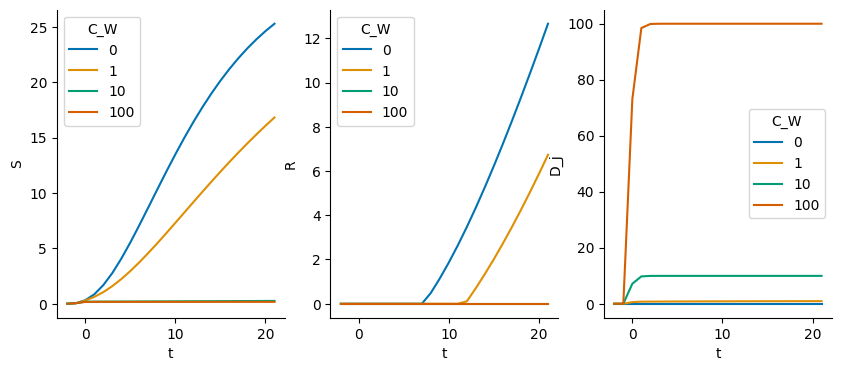

In [10]:
exposures = [0, 1, 10, 100] # define exposure concentrations
sim = constant_exposures(simulate_DEBBase, defaultparams_DEBBase, exposures) # run model with given parameters for each exposure

statevars = ["S", "R", "D_j"] # state variables to plot
fig, ax = plt.subplots(ncols = len(statevars), figsize = (10,4)) # create subplots according to number of state variables

for (i,y) in enumerate(statevars):
    sns.lineplot(
        sim, x = "t", y = y, # plotting state over time
        hue = "C_W", # grouping variable
        palette = sns.color_palette("colorblind", len(exposures)), # define length of the color palette to avoid warning
        ax = ax[i] # plot on the ith subplot
        )

sns.despine() # removes bounding box

You should see that both `R` and `S` are affected as the scaled damage `D_j` increases. <br>
This is because the default parameters assume `G` as the PMoA, i.e. a decrease in growth efficiency (increase in growth costs). <br>
We can change this through the corresponding entry in the parameters. Setting the PMoA to `R`, we should only see a decrease in the reproduction buffer `R`.

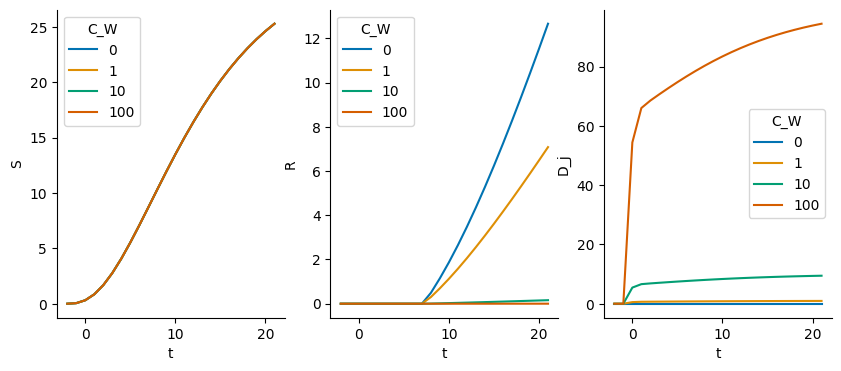

In [11]:
exposures = [0, 1, 10, 100]

pars = deepcopy(defaultparams_DEBBase) # create copy of default parameters 
pars.spc["pmoa"] = "R" # setting the PMoA 

sim = constant_exposures(simulate_DEBBase, pars, exposures) # simulate exposures

statevars = ["S", "R", "D_j"] # state variables to plot
fig, ax = plt.subplots(ncols = len(statevars), figsize = (10,4)) # create subplots according to number of state variables

for (i,y) in enumerate(statevars):
    sns.lineplot(
        sim, x = "t", y = y, # plotting state over time
        hue = "C_W", # grouping variable
        palette = sns.color_palette("colorblind", len(exposures)), # define length of the color palette to avoid warning
        ax = ax[i] # plot on the ith subplot
        )

sns.despine() # removes bounding box

That's it for now - these are all the basics you need to get started with `mempyDEB`.